In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm, trange

import torch
from haloflow import data as D
from haloflow import util as U

In [2]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
if torch.cuda.is_available(): device = 'cuda:0'
else: device = 'cpu'

## read $q_\phi(Y\,|\,X)$

809 models trained
[594, 316, 732, 508, 358]


/groups/chhahn/haloflow/src/haloflow/util.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qphi = torch.load(fqphi, map_location=device)
/groups/chhahn/haloflow/src/halo

693 models trained
[481, 477, 664, 370, 640]
556 models trained
[538, 312, 163, 496, 497]
799 models trained
[706, 410, 492, 665, 725]
670 models trained
[589, 199, 331, 363, 121]
1010 models trained
[848, 408, 129, 562, 150]
343 models trained
[327, 293, 244, 300, 199]
444 models trained
[124, 132, 156, 214, 382]
267 models trained
[135, 145, 122, 91, 217]
239 models trained
[235, 214, 198, 153, 169]


Text(0.5, 0, 'true $\\log M_h$')

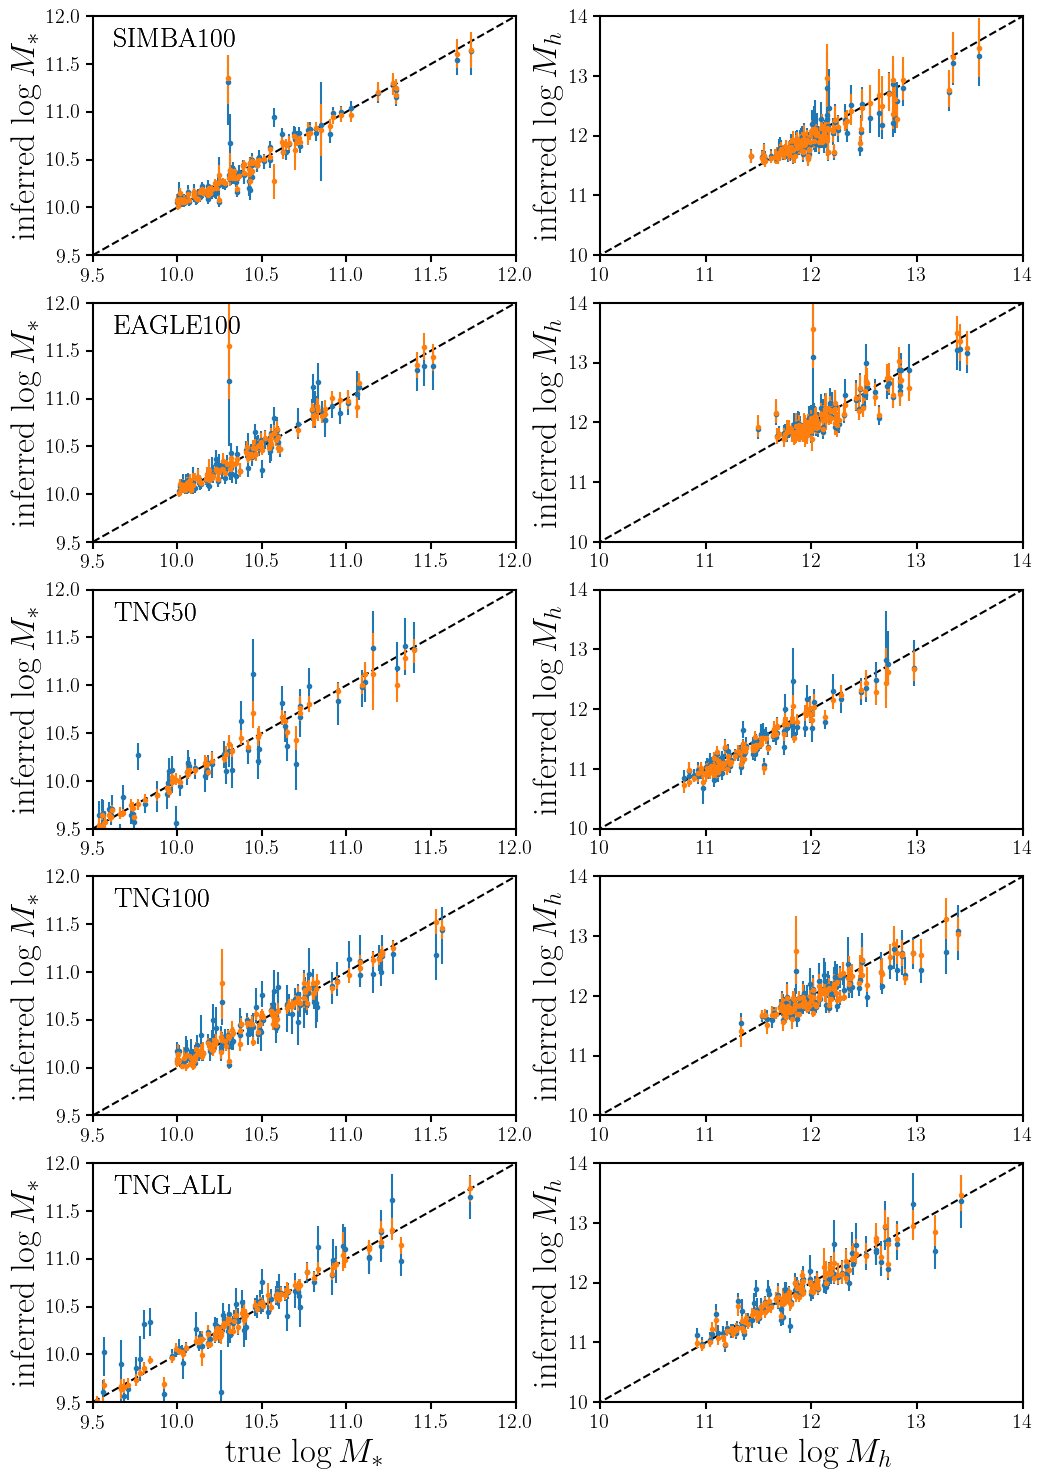

In [4]:
fig = plt.figure(figsize=(12,18))

for i_sim, sim in enumerate(['Simba100', 'Eagle100', 'TNG50', 'TNG100', 'TNG_ALL']): 
    # plot 
    sub0 = fig.add_subplot(5,2,2*i_sim+1)
    sub0.plot([9.5, 12.], [9.5, 12.], c='k', ls='--')
    
    sub1 = fig.add_subplot(5,2,2*i_sim+2)
    sub1.plot([9.5, 14.], [9.5, 14.], c='k', ls='--')

    # test-data
    Y_test, _ = D.hf2_centrals('test', 'mags_morph', sim=sim)

    igals = np.random.choice(np.arange(Y_test.shape[0]), size=100, replace=False)
    y_true = Y_test[igals]
    
    for i_obs, obs in enumerate(['mags', 'mags_morph']): 
        # read q_phis
        qphis = U.read_best_ndes('h2.v1.%s.%s' % (sim, obs), n_ensemble=5, device=device, 
                             dat_dir='/xdisk/chhahn/chhahn/haloflow/hf2/npe', verbose=True)
        Y_test, X_test = D.hf2_centrals('test', obs, sim=sim)        

        # sample NDEs
        n_sample = 1000
        y_nde = [] 
        for i in igals: 
            y_samp = []
            for qphi in qphis: 
                _samp = qphi.sample((int(n_sample/len(qphis)),),
                                       x=torch.tensor(X_test[i], dtype=torch.float32).to(device), 
                                       show_progress_bars=False)
                y_samp.append(_samp.detach().cpu().numpy())
            y_nde.append(np.concatenate(np.array(y_samp), axis=0)) 
        y_nde = np.array(y_nde)
        y_nde_q0, y_nde_q1, y_nde_q2 = np.quantile(y_nde, (0.16, 0.5, 0.84), axis=1)
    
        # plot comparison
        sub0.text(0.05, 0.95, sim.upper(), transform=sub0.transAxes, ha='left', va='top', fontsize=20)
        sub0.errorbar(y_true[:,0], y_nde_q1[:,0], 
                     yerr=[y_nde_q1[:,0] - y_nde_q0[:,0], y_nde_q2[:,0] - y_nde_q1[:,0]], fmt='.C%i' % i_obs)
        sub1.errorbar(y_true[:,1]+0.05, y_nde_q1[:,1], 
                     yerr=[y_nde_q1[:,1] - y_nde_q0[:,1], y_nde_q2[:,1] - y_nde_q1[:,1]], fmt='.C%i' % i_obs)

    sub0.set_ylabel(r'inferred $\log M_*$', fontsize=25)
    sub0.set_xlim(9.5, 12.)
    sub0.set_ylim(9.5, 12.)
    
    sub1.set_ylabel(r'inferred $\log M_h$', fontsize=25)
    sub1.set_xlim(10., 14.)
    sub1.set_ylim(10., 14.)
    
sub0.set_xlabel(r'true $\log M_*$', fontsize=25)

sub1.set_xlabel(r'true $\log M_h$', fontsize=25)